## Student ID
>> `Zeynab Mottaqi`

>> `99206203`

In [1]:
'''

Packages

'''

import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor 


In [2]:
'''

Tools

'''
def Data_to_Categorical(x, categs=None):
    if not categs:
        categs = np.amax(x) + 1
    
    Encodes = np.zeros((x.shape[0],categs))
    Encodes[np.arange(x.shape[0]),x] = 1
    return Encodes 

def Accuracy(y_real,y_pred):
    return np.sum(y_real == y_pred,axis=0) / len(y_real)


def Batching(X,y = None, batch = 64):
    N_samples = X.shape[0]
    for i in np.arange(0,N_samples,batch):
        top, bottom = i, min(i+batch,N_samples)
        if y is not None:
            yield X[top:bottom], y[top:bottom]
        else:
            yield X[top:bottom]

In [3]:
## DataSet
Train = FashionMNIST(train=True, root='data',download=True,transform=ToTensor())
Test = FashionMNIST(train=False, root='data',download=True,transform=ToTensor())
Classes = Test.classes


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



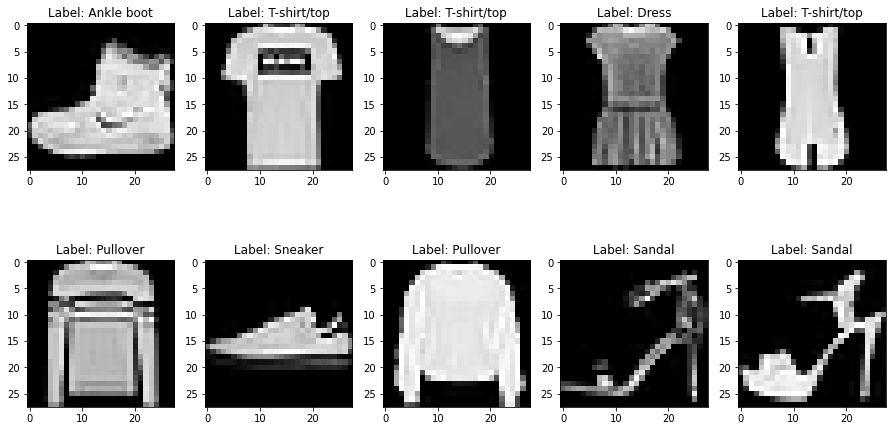

In [4]:
Index = np.arange(0,10)

fig ,axes = plt.subplots(2,5,figsize=(12.5,7))

for i in range(len(Index)):
    ax = axes[i//5, i%5]
    ax.imshow(np.reshape(Train.data[i],(28,28)), cmap='gray')
    ax.set_title('Label: {}'.format(Classes[Train.targets[i]]))
plt.tight_layout()
plt.show()

In [5]:
# Manipulating the data
X_train = Tensor.numpy(Train.data).reshape(-1,784)
y_train = Tensor.numpy(Train.targets)
X_test = Tensor.numpy(Test.data).reshape(-1,784)
y_test = Tensor.numpy(Test.targets)

In [6]:
## Convert to categorical
y_train_C, y_test_C = Data_to_Categorical(y_train.astype("int")),Data_to_Categorical(y_test.astype("int"))
X_train, X_test = X_train/255.0 , X_test/255.0


In [7]:
## Neurons

N_Dim = 28*28
N_Out = 10
N_Hid = 256

In [8]:
# Loss Calculation
class CrossEntropy():
    def __init__(self) -> None:
        pass
    def Loss(self,y_true, pred):
        pred = np.clip(pred, 1e-15,1-1e-15)
        return -y_true*np.log(pred) - (1-y_true)*np.log(1-pred)
    
    def Gradient(self,y_true, pred):
        pred = np.clip(pred, 1e-15,1-1e-15)
        return -(y_true/pred) + (1-y_true)/(1-pred)


In [9]:
# Activation functions 
class Relu():
    def __init__(self) -> None:
        pass

    def __call__(self, x):
        return self.Act(x)
    def Act(self,x):
        return np.where(x >= 0,x,0.0)
    
    def Gradient(self,x):
        return np.where(x >= 0,1,0.0)


class SoftMax():
    def __init__(self) -> None:
        pass

    def __call__(self, x):
        return self.Act(x)

    def Act(self,x):
        tmp = np.exp(x-np.max(x,axis=-1,keepdims=True))
        return tmp/np.sum(tmp,axis=-1,keepdims=True)
    
    def Gradient(self,x):
        tmp = self.Act(x)
        return tmp * (1 - tmp)

In [10]:
# Wrappers for Neural Network
class Act_wrapper():
    def __init__(self,Act,Tag="Phi"):
        self.Act = Act
        self.Grad = Act.Gradient
        self.In = None
        self.Out = None
        self.Tag = Tag
    
    def Forward(self,x):
        self.In = x
        self.Out = self.Act(x)
        return self.Out

    def Backward(self,Error,lr=0.01):
        return self.Grad(self.In) * Error

    def __call__(self, x):
        return self.Forward(x)
        
class Lin_Connector():
    def __init__(self,N_In,N_Out,Tag="Connectivity"):
        self.W = 0.01*np.random.randn(N_In,N_Out)
        self.b = np.zeros((1,N_Out))
        self.In = None
        self.Out = None
        self.Tag = Tag
    
    def Forward(self,x):
        self.In = x
        self.Out = np.dot(self.In,self.W) + self.b

        return self.Out

    def Backward(self,Error,lr=0.01):
        Diff = np.dot(Error,self.W.T)
        tmp = np.dot(self.In.T,Error)
        self.W -= lr * tmp
        self.b -= lr * np.mean(Error)
        return Diff

    
    def __call__(self, x):
        return self.Forward(x)

In [11]:
# Main Model
class MyNet():
    def __init__(self,In_dim,Out_dim,Hid_dim,lr=0.01):
        self.layers = [
            Lin_Connector(In_dim,Hid_dim,Tag="First Layer"),
            Act_wrapper(Relu(),Tag="Phi1"),
            Lin_Connector(Hid_dim,Hid_dim,Tag="Second Layer"),
            Act_wrapper(Relu(),Tag="Phi2"),
            Lin_Connector(Hid_dim,Out_dim,Tag="Last Layer"),
            Act_wrapper(SoftMax(),Tag="SoftMax")
        ]
        self.lr = lr

    def Forward(self,x):
        for tmp in self.layers:
            x = tmp(x)
        return x
    
    def Backward(self,Loss):
        for tmp in reversed(self.layers):
            Loss = tmp.Backward(Loss,self.lr)

    def __call__(self,x):
        return self.Forward(x)
        


In [12]:
Cost = CrossEntropy()
Model = MyNet(N_Dim,N_Out,N_Hid,lr=0.001)

In [13]:
Epochs = 5
for i in range(Epochs):
    loss = []
    Acc = []
    for Batch_X,Batch_y in Batching(X_train,y_train_C):
        Pred = Model(Batch_X)
        loss.append(np.mean(Cost.Loss(Batch_y,Pred)))
        Acc.append(Accuracy(np.argmax(Batch_y,axis=1),np.argmax(Pred,axis=1)))
        Error = Cost.Gradient(Batch_y,Pred)
        Model.Backward(Error)
    print(f"At Epoch {i+1} / {Epochs},Maximum Loss of Batch = {np.mean(loss):2.2E}\n\
        , With Accuracy = {np.mean(Acc)*100:2.2f}%.")

At Epoch 1 / 5,Maximum Loss of Batch = 1.82E-01
        , With Accuracy = 57.73%.
At Epoch 2 / 5,Maximum Loss of Batch = 9.98E-02
        , With Accuracy = 79.07%.
At Epoch 3 / 5,Maximum Loss of Batch = 8.28E-02
        , With Accuracy = 83.04%.
At Epoch 4 / 5,Maximum Loss of Batch = 7.39E-02
        , With Accuracy = 84.90%.
At Epoch 5 / 5,Maximum Loss of Batch = 6.84E-02
        , With Accuracy = 86.03%.


In [14]:
# Validation 
Prediction = Model(X_test)
Pred_Acc = Accuracy(np.argmax(y_test_C, axis=1),np.argmax(Prediction,axis=1))   
Pred_Loss = np.mean(Cost.Loss(y_test_C,Prediction))
print(f"The Validation Accuracy is {Pred_Acc*100:2.2f}%,\
     And Validation Loss is {Pred_Loss:2.2E}.")

The Validation Accuracy is 85.17%,     And Validation Loss is 7.11E-02.


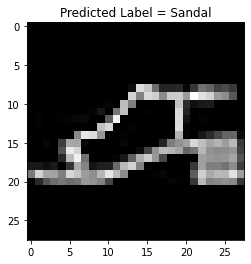

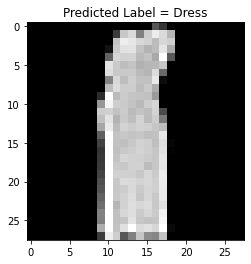

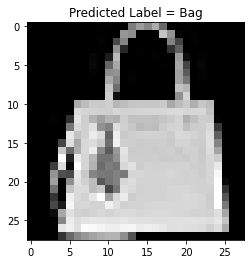

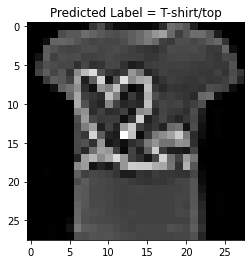

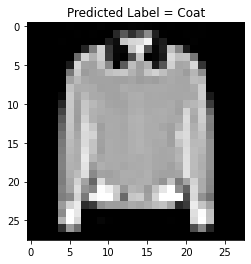

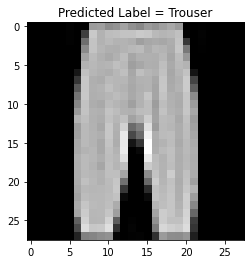

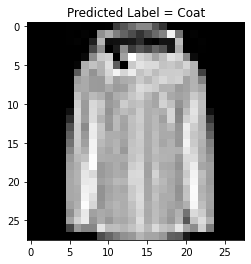

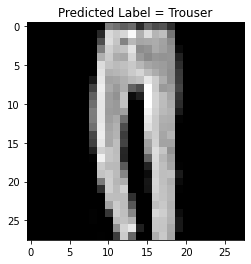

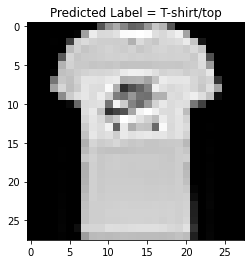

In [15]:
np.random.seed(1000)
random_index = np.random.randint(low=0,high=len(y_test_C),size=9)
X,Y = X_test[random_index,:],y_test_C[random_index]
Y_P = np.argmax(Model(X),axis=1)

for i,j in enumerate(random_index):
    plt.imshow(X[i,:].reshape(28,28),cmap='gray')
    plt.title("Predicted Label = %s" %Classes[Y_P[i]])
    plt.show()

